In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# !pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found e

## Importing the Libraries

In [3]:
import tensorflow as tf
import os
import keras
from keras import ops
from keras.layers import Input, Conv2D, LSTM, MaxPooling2D, Reshape, Bidirectional, Dense, Flatten, Dropout, StringLookup, Layer
from keras.optimizers import Adam
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.callbacks import Callback

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

## Loading the Dataset

In [4]:
folder_path = '/content/drive/MyDrive/Captcha_version_2_Images_Dataset/samples'

data_dir = Path(folder_path)

# The dataset contains 1040 captcha files as png images. The label for each sample is a string, the name of the file.
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

batch_size = 16

# Image Dimensions
img_width = 200
img_height = 50

downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])
print('Maximum length of the captcha that would be processed :',max_length)

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
Maximum length of the captcha that would be processed : 5


## Pre-Processing the Dataset

In [6]:
# Mapping each character of string (labels) to an integer for training the model

# Defining a 'char_to_num' layer which will map strings to integers
# Here vocabulary is list of characters which an input string will take
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)
print(char_to_num.get_vocabulary())

# Mapping integer back to character
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)


# Split data into training, validation and testing sets
def split_data(images, labels, test_size=0.2, shuffle=True):

    # first split the original into train and test , train be 80% of original and test be 20% of original
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = test_size, shuffle=shuffle)

    x_valid, x_test, y_valid, y_test = train_test_split(images, labels, test_size = 0.5, shuffle=shuffle)

    # Finally: train - 80% , valid - 10% , test - 10%
    return x_train, x_valid, x_test, y_train, y_valid, y_test

x_train, x_valid, x_test, y_train, y_valid, y_test = split_data(np.array(images), np.array(labels))

def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)

    img = tf.io.decode_png(img, channels=1)

    img = tf.image.convert_image_dtype(img, tf.float32)

    img = ops.image.resize(img, [img_height, img_width])

    img =  ops.transpose(img, axes=[1, 0, 2])

    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    return {"image": img, "label": label}



['[UNK]', '2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


## Create Dataset objects

In [ ]:
# batch_size  is 16

# Creates a dataset where each element is a tuple (x_train[i], y_train[i])
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# Batches the dataset into smaller sets of size batch_size.
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (
    test_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## Visualizing the dataset

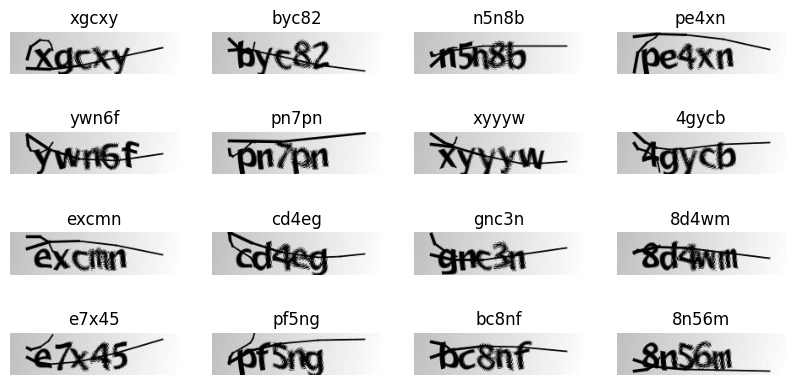

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label_str = "".join(num_to_char(labels[i]).numpy().astype(str))
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label_str)
        ax[i // 4, i % 4].axis("off")
plt.show()

## Building the Model

In [ ]:
def build_model(input_shape, num_classes):
    # Inputs to the model
    input_img = Input(shape=input_shape, name="image", dtype="float32")
    labels = Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")(input_img)
    x = MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2")(x)
    x = MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller.
    # The number of filters in the last layer is 64.
    # Reshape accordingly before passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = Reshape(target_shape=new_shape, name="reshape")(x)
    x = Dense(64, activation="relu", name="dense1")(x)
    x = Dropout(0.2)(x)

    # RNNs
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25),name='bidirectional_lstm1')(x)
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25),name='bidirectional_lstm2')(x)

    # Output layer
    x = Dense(num_classes, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = Model(inputs=[input_img, labels], outputs=output, name="ocr_model")

    return model

class CTCLayer(Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = ops.cast(ops.shape(y_true)[0], dtype="int64")
        input_length = ops.cast(ops.shape(y_pred)[1], dtype="int64")
        label_length = ops.cast(ops.shape(y_true)[1], dtype="int64")

        input_length = input_length * ops.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * ops.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    label_length = ops.cast(ops.squeeze(label_length, axis=-1), dtype="int32")
    input_length = ops.cast(ops.squeeze(input_length, axis=-1), dtype="int32")
    sparse_labels = ops.cast(
        ctc_label_dense_to_sparse(y_true, label_length), dtype="int32"
    )

    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())

    return ops.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )


def ctc_label_dense_to_sparse(labels, label_lengths):
    label_shape = ops.shape(labels)
    num_batches_tns = ops.stack([label_shape[0]])
    max_num_labels_tns = ops.stack([label_shape[1]])

    def range_less_than(old_input, current_input):
        return ops.expand_dims(ops.arange(ops.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )

    init = ops.cast(tf.fill([1, label_shape[1]], 0), dtype="bool")
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]

    label_array = ops.reshape(
        ops.tile(ops.arange(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)

    batch_array = ops.transpose(
        ops.reshape(
            ops.tile(ops.arange(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = ops.transpose(
        ops.reshape(ops.concatenate([batch_ind, label_ind], axis=0), [2, -1])
    )

    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        ops.cast(indices, dtype="int64"),
        vals_sparse,
        ops.cast(label_shape, dtype="int64")
    )


input_shape = (img_width, img_height, 1)
num_classes = len(char_to_num.get_vocabulary()) + 1

model = build_model(input_shape,num_classes)
model.summary()


Model: "ocr_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 200, 50, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 200, 50, 32)    │            320 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 100, 25, 32)    │              0 │ Conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2 (Conv2D)            │ (None, 100, 25, 64)    │         18,496 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool2 (MaxPooling2D)      │ (None, 50, 12, 64)     │              0 │ Conv2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 50, 768)        │              0 │ pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 50, 64)         │         49,216 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 50, 64)         │              0 │ dense1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_lstm1       │ (None, 50, 256)        │        197,632 │ dropout_1[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_lstm2       │ (None, 50, 128)        │        164,352 │ bidirectional_lstm1[0… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 50, 21)         │          2,709 │ bidirectional_lstm2[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc_loss (CTCLayer)       │ (None, 50, 21)         │              0 │ label[0][0],           │
│                           │                        │                │ dense2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 432,725 (1.65 MB)

 Trainable params: 432,725 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [ ]:
# TODO restore epoch count.
epochs = 100
early_stopping_patience = 10

# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Compile the model
model.compile(optimizer=Adam(), loss=None)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 430ms/step - loss: 32.9812 - val_loss: 16.3954
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 391ms/step - loss: 16.3909 - val_loss: 16.3722
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 458ms/step - loss: 16.3791 - val_loss: 16.3704
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 413ms/step - loss: 16.3713 - val_loss: 16.3636
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 417ms/step - loss: 16.3420 - val_loss: 16.3469
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 398ms/step - loss: 16.3492 - val_loss: 16.3525
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 386ms/step - loss: 16.3478 - val_loss: 16.3466
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 418ms/step - loss: 16.3347 - val_loss: 16.3397
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 39s 388ms/step - loss: 16.3282 - val_loss: 16.3331
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 422ms/step - loss: 16.3297 - val_loss: 16.3354
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 391ms/step - loss: 16.3354 - val_loss: 16.3218
Epoch 12

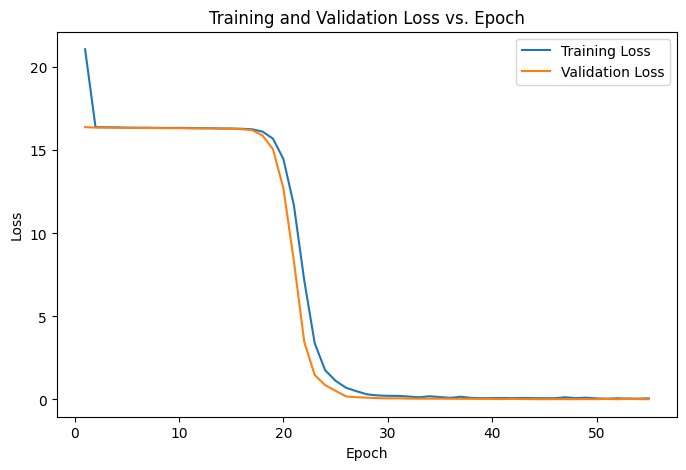

In [ ]:
import matplotlib.pyplot as plt

# Get training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss vs. epoch
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model Inference

Model: "ocr_model_for_inference"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)                   │ (None, 200, 50, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 200, 50, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 100, 25, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 100, 25, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 50, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 50, 768)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 50, 64)              │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_lstm1 (Bidirectional)  │ (None, 50, 256)             │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_lstm2 (Bidirectional)  │ (None, 50, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 50, 21)              │           2,709 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 432,725 (1.65 MB)

 Trainable params: 432,725 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


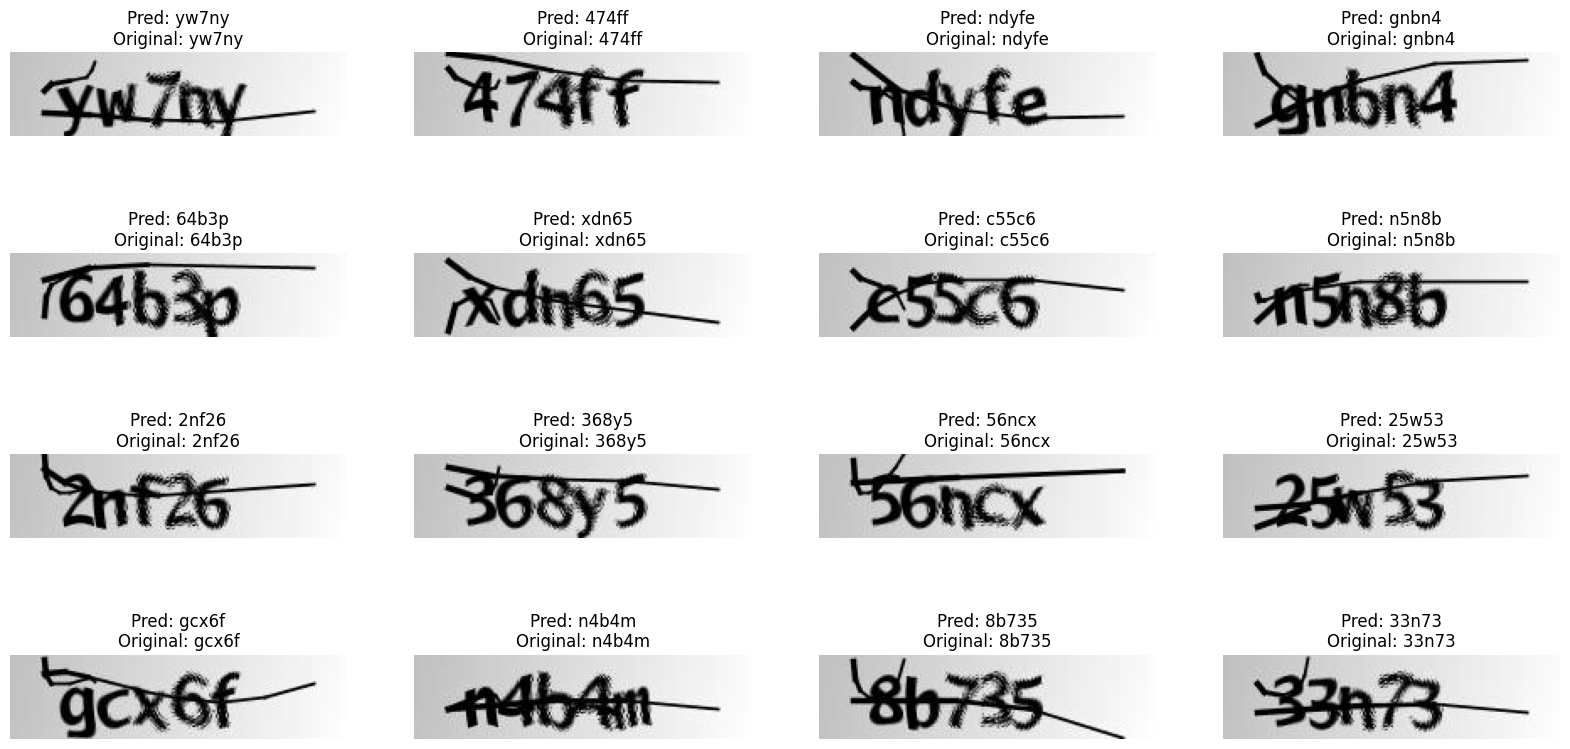

Processed 1 batch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
Processed 2 batch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
Processed 3 batch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
Processed 4 batch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
Processed 5 batch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Processed 6 batch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Processed 7 batch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Processed 8 batch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Processed 9 batch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Processed 10 batch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Processed 11 batch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Processed 12 batch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Processed 13 batch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Processed 14 batch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Processed 15 batch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Processed 16 batch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Processed 17 batch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Processed 18 batch
1/1 ━━━━━━━━━━━━

In [ ]:
def ctc_decode(y_pred, input_length, greedy=True, beam_width=100, top_paths=1):
    input_shape = ops.shape(y_pred)
    num_samples, num_steps = input_shape[0], input_shape[1]
    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())
    input_length = ops.cast(input_length, dtype="int32")

    if greedy:
        (decoded, log_prob) = tf.nn.ctc_greedy_decoder(
            inputs=y_pred, sequence_length=input_length
        )
    else:
        (decoded, log_prob) = tf.compat.v1.nn.ctc_beam_search_decoder(
            inputs=y_pred,
            sequence_length=input_length,
            beam_width=beam_width,
            top_paths=top_paths,
        )
    decoded_dense = []
    for st in decoded:
        st = tf.SparseTensor(st.indices, st.values, (num_samples, num_steps))
        decoded_dense.append(tf.sparse.to_dense(sp_input=st, default_value=-1))
    return (decoded_dense, log_prob)


# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        decoded_text = "".join(num_to_char(res).numpy().astype(str))
        output_text.append(decoded_text)
    return output_text

# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.input[0], model.get_layer(name="dense2").output,name='ocr_model_for_inference'
)
prediction_model.summary()

#  Let's check the results on some validation samples
all_orig_texts = []
all_pred_texts = []

for index, batch in enumerate(test_dataset):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    # Get predictions for the batch
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    # Store predicted and original texts for the batch
    for label in batch_labels:
        orig_text = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        all_orig_texts.append(orig_text)

    all_pred_texts.extend(pred_texts)

    # Showcase only the first batch
    if index == 0:
        _, ax = plt.subplots(4, 4, figsize=(20, 10))
        for i in range(len(pred_texts)):
            img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
            img = img.T
            pred_text = pred_texts[i]
            orig_text = all_orig_texts[i]
            title = f"Pred: {pred_text}\nOriginal: {orig_text}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
        plt.show()

    print(f'Processed {index + 1} batch')



In [ ]:
correct_predictions = 0
total_predictions = len(all_orig_texts)

for orig_text, pred_text in zip(all_orig_texts, all_pred_texts):
    if orig_text == pred_text:
        correct_predictions += 1

accuracy = correct_predictions / total_predictions
print(f"Accuracy after evaluating on Test Dataset: {accuracy * 100:.2f}%")

Accuracy after evaluating on Test Dataset: 97.68%


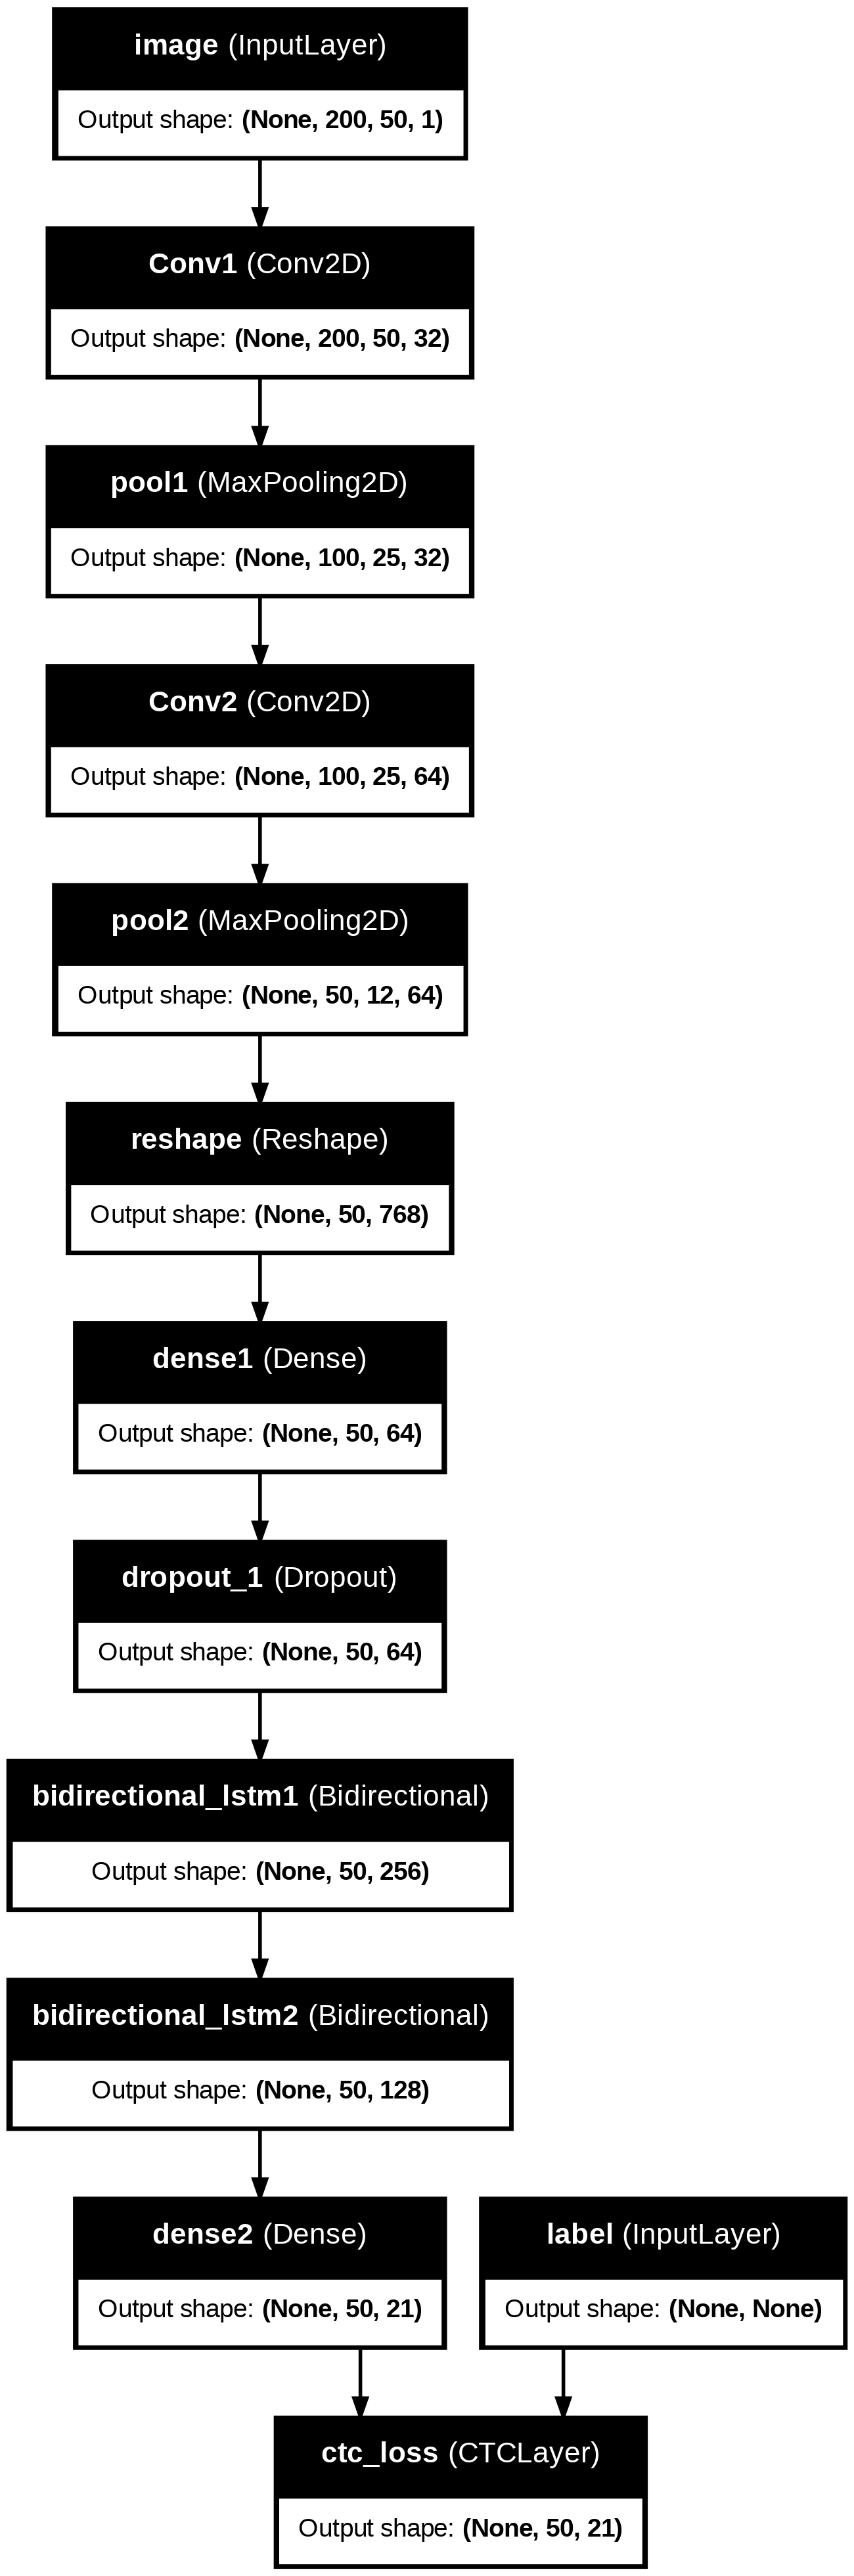

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
